# Experiment 01: Influence of number of centers

In [50]:
%matplotlib inline

import os
import sys
import copy
import time
import pickle
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data 2D

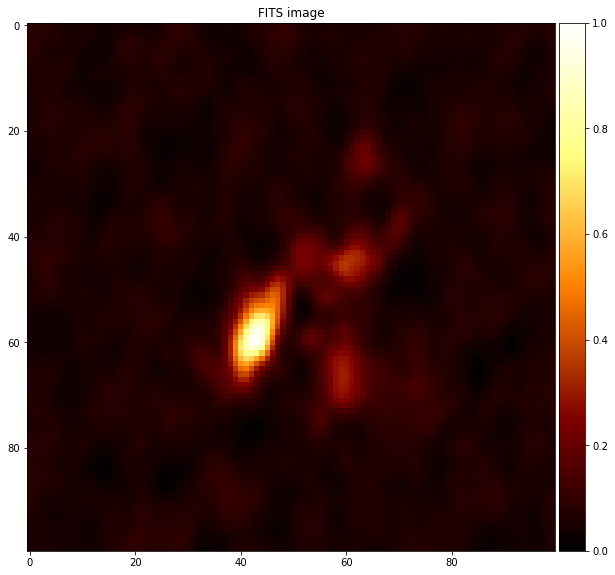

In [2]:
"""
Loading data
"""

fits_path = '../data/images/Orion.cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [ ]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

/home/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)
Widget Javascript not detected.  It may not be installed or enabled properly.


<function graph.thresholded_image_plot>

In [ ]:
# common parameters
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig


elm_list = list()

for Np in range(50, 801, 25):
    # number of points of each type
    Nb = int(Np*0.2)
    Nc = int(Np*0.8)
    Ne = 4*Nc-Nb
    
    # points generation
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=5.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_generation(Nb)
    
    # right format
    xc = center_points[:,0]
    yc = center_points[:,1]
    xe = collocation_points[:,0]
    ye = collocation_points[:,1]
    xb = boundary_points[:,0]
    yb = boundary_points[:,1]
    
#    # visualizing the choosen points
#    points_plot(data, center_points=center_points, title="Center Points")
#    points_plot(data, center_points=collocation_points, title="Collocation Points")


    ####################################
    # Initial parameters estimation
    ####################################
    #c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
    c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')
    #c0, sig0 = _estimate_initial_guess(dfunc, data, center_points, base_level)


#    solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
#    params_plot(c0, sig0, xc, yc)
#    params_distribution_plot(c0, sig0)
    elm_list.append(ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                    d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.))

In [ ]:
for elm in elm_list:
    print('#'*90)
    print('Processing {0} centers example'.format(len(elm.c)))
    print('#'*90 + '\n')
    nfev = 100*(len(elm.get_params())+1)
    elm_solver(elm, method='standard', max_nfev=nfev)
    
#pickling results
target = open("elm_list.pkl", "wb")
pickle.dump(elm_list, target)
target.close()

## Analysis of results in `Orion KL`

In [3]:
elm_list = pickle.load( open('../results/elm_list_orion.pkl', 'rb') )

In [5]:
n_center = [len(elm.c) for elm in elm_list]
r_stats = [elm.get_residual_stats() for elm in elm_list]
variance = [var for (var,_,_) in r_stats]
entropy = [entr for (_,entr,_) in r_stats]
rms = [rms for (_,_,rms) in r_stats]

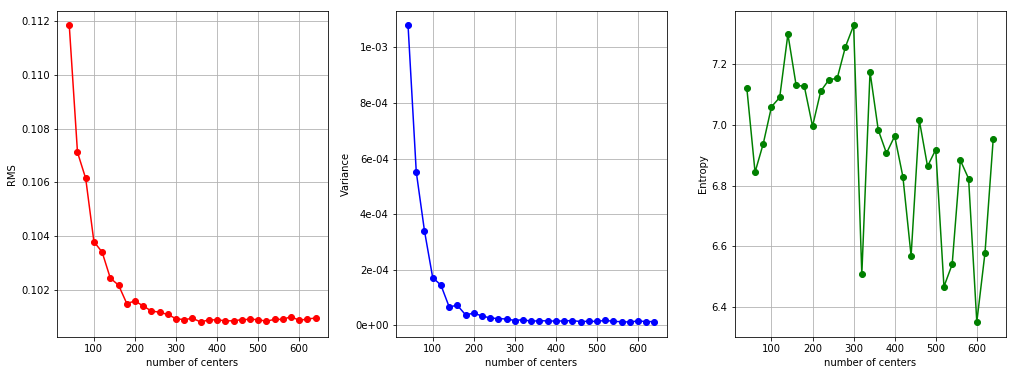

In [70]:
fig = plt.figure(figsize=(17,6))
fig.subplots_adjust(wspace=0.25)
plt.subplot(1,3,1)
plt.plot(n_center, rms, 'ro-')
#plt.title('RMS')
plt.grid()
plt.xlabel('number of centers')
plt.ylabel('RMS')

ax = plt.subplot(1,3,2)
plt.plot(n_center, variance, 'bo-')
#plt.title('Entropy')
plt.grid()
plt.xlabel('number of centers')
plt.ylabel('Variance')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

plt.subplot(1,3,3)
plt.plot(n_center, entropy, 'go-')
#plt.title('Entropy')
plt.grid()
plt.xlabel('number of centers')
plt.ylabel('Entropy')

plt.show()